In [10]:
from __future__ import print_function

import os
import sys
import glob
import h5py
import numpy as np
import math


import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset , DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorboard
import tensorboardX
from torch.utils.tensorboard import SummaryWriter


from log import Logger
from data import  trainDataset, testDataset, trainlabelDataset,testlabelDataset
from util import r2, mse, rmse, mae, pp_mse, pp_rmse, pp_mae
from model import autoencoder_999, autoencoder_333

def to_img(x):   # image size 
    x = x.view(x.size(0), 1, 64, 64)
    return x

In [ ]:

if not os.path.exists('./gal_img1001'):
    os.mkdir('./gal_img1001')

    
dataset= trainlabelDataset()
dataloader= DataLoader(dataset=dataset, batch_size=64,shuffle=True)

test_dataset = testlabelDataset()
test_dataloader= DataLoader(dataset=test_dataset, batch_size=64,shuffle=True)


writer = SummaryWriter("run1001/exp301",)  ################################################### change name 

num_epochs =20000
batch_size = 64
learning_rate = 5e-1




model = autoencoder_333().cuda()   ############################################################## AE model 
criterion = nn.L1Loss()

#scheduler 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,4000], gamma=0.1)







for epoch in range(num_epochs):
    total_loss = 0.0
    total_mse = 0.0 
    num_examples = 0.0
    test_num_examples=0.0
    
    
    test_total_loss = 0.0    
    test_total_mse=0.0
    
    model.train()
    for data in dataloader:
        img,label= [x.type(torch.float32).cuda() for x in data]
        img = img.view(img.size(0), 1,64,64)

      #  print(img.shape)
        # forward
        output, z = model(img)
        z=z.view(z.size(0),14*14)
       # print("output ",output.shape)
       # print("z ",z.shape)
    ################################################## Loss function with regularizing Z ########################
        loss = criterion(output, img) +  1e-5* criterion(z[:,:7], label)  # + 1e-7*torch.norm(z,p=1)
        
        
        MSE_loss = nn.MSELoss()(output, img)
        batch_size = img.size(0)
        total_loss += loss.item() * batch_size
        total_mse += MSE_loss.item() * batch_size
        num_examples += batch_size

        
        optimizer.zero_grad()
    # backward
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    model.eval()
    for data in test_dataloader:
        test_img,test_label= [x.type(torch.float32).cuda() for x in data]

        test_img = test_img.view(test_img.size(0), 1,64,64)
       # print(img.shape)
        

        # forward
        test_output,test_z = model(test_img)
        test_z=test_z.view(test_z.size(0),14*14)
                
       #print("output ",output.shape)
        test_loss = criterion(test_output, test_img)  + 1e-5*  criterion(test_z[:,:7], test_label) 
        
        
        test_MSE_loss = nn.MSELoss()(test_output, test_img)
        batch_size = test_img.size(0)
        test_total_loss += test_loss.item() * batch_size
        test_total_mse += test_MSE_loss.item() * batch_size
        test_num_examples += batch_size

        
    writer.add_scalar('Loss/train',total_loss / num_examples,epoch)
    writer.add_scalar('Mse/train', total_mse / num_examples,epoch)        
    writer.add_scalar('Loss/test',test_total_loss / test_num_examples,epoch)
    writer.add_scalar('Mse/test', test_total_mse / test_num_examples,epoch)
    

    
    print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
          .format(epoch + 1, num_epochs, total_loss / num_examples, total_mse/ num_examples))    
    print(' epoch [{}/{}],test_loss:{:.4f}, test_MSE_loss:{:.4f}'
          .format(epoch + 1, num_epochs, test_total_loss / test_num_examples, test_total_mse/ test_num_examples))

    if epoch % 10 == 0:
        x = to_img(img.cpu().data)
        x_hat = to_img(output.cpu().data)
        test_x = to_img(test_img.cpu().data)    ########## change name 
        test_x_hat = to_img(test_output.cpu().data)
        torch.save(x, './gal_img1001/exp301_x_{}.pt'.format(epoch))
        torch.save(x_hat, './gal_img1001/exp301_x_hat_{}.pt'.format(epoch))
        torch.save(test_x, './gal_img1001/exp301_test_x_{}.pt'.format(epoch))
        torch.save(test_x_hat, './gal_img1001/exp301_test_x_hat_{}.pt'.format(epoch))
        torch.save(model.state_dict(), './gal_img1001/exp301_{}.pth'.format(epoch))       
           
    



epoch [1/20000], loss:73.2064, MSE_loss:354.3821
 epoch [1/20000],test_loss:441.5827, test_MSE_loss:1669347737.6017
epoch [2/20000], loss:71.9073, MSE_loss:0.2877
 epoch [2/20000],test_loss:4740.1968, test_MSE_loss:25456485.5360
epoch [3/20000], loss:71.8725, MSE_loss:0.0033
 epoch [3/20000],test_loss:77.8704, test_MSE_loss:5899584.1756
epoch [4/20000], loss:72.3535, MSE_loss:9.4113
 epoch [4/20000],test_loss:496.4930, test_MSE_loss:478053991.8151
epoch [5/20000], loss:71.9649, MSE_loss:0.0811
 epoch [5/20000],test_loss:92.3341, test_MSE_loss:507.6471
epoch [6/20000], loss:71.9419, MSE_loss:0.0160
 epoch [6/20000],test_loss:72.5208, test_MSE_loss:0.0313
epoch [7/20000], loss:71.8860, MSE_loss:0.0162
 epoch [7/20000],test_loss:72.3458, test_MSE_loss:0.0000
epoch [8/20000], loss:71.8283, MSE_loss:0.0000
 epoch [8/20000],test_loss:72.3459, test_MSE_loss:0.0000
epoch [9/20000], loss:71.8291, MSE_loss:0.0000
 epoch [9/20000],test_loss:72.3472, test_MSE_loss:0.0000
epoch [10/20000], loss:71.

In [16]:
img.view(64,64,64)

tensor([[[3.5068e-05, 3.8054e-05, 4.1302e-05,  ..., 5.2289e-05,
          4.8109e-05, 4.4260e-05],
         [3.6988e-05, 4.0199e-05, 4.3699e-05,  ..., 5.5068e-05,
          5.0581e-05, 4.6459e-05],
         [3.8997e-05, 4.2448e-05, 4.6218e-05,  ..., 5.7962e-05,
          5.3147e-05, 4.8736e-05],
         ...,
         [4.8736e-05, 5.3147e-05, 5.7962e-05,  ..., 4.6218e-05,
          4.2448e-05, 3.8997e-05],
         [4.6459e-05, 5.0581e-05, 5.5068e-05,  ..., 4.3699e-05,
          4.0199e-05, 3.6988e-05],
         [4.4260e-05, 4.8109e-05, 5.2289e-05,  ..., 4.1302e-05,
          3.8054e-05, 3.5068e-05]],

        [[4.3154e-05, 5.0554e-05, 5.9591e-05,  ..., 1.1558e-05,
          1.0778e-05, 1.0059e-05],
         [4.3020e-05, 5.0338e-05, 5.9277e-05,  ..., 1.2268e-05,
          1.1421e-05, 1.0640e-05],
         [4.2917e-05, 5.0151e-05, 5.8988e-05,  ..., 1.3020e-05,
          1.2100e-05, 1.1254e-05],
         ...,
         [1.1254e-05, 1.2100e-05, 1.3020e-05,  ..., 5.8988e-05,
          5.015

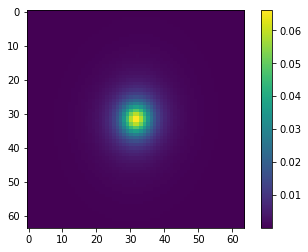

In [21]:
plt.imshow(img[0].view(64,64).cpu().numpy())
plt.colorbar()

In [20]:
img[0].shape

torch.Size([1, 64, 64])

In [ ]:
1+1